## ML QA: Question & Answering

Dataset Source: https://huggingface.co/datasets/mlqa/viewer/mlqa.en.en/test

#### Install Necessary Libraries

In [ ]:
%pip install pip -U
%pip install torch datasets evaluate
%pip install transformers tensorboard
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/46/3e/e1a12ac147ad460f67bd59ce9fede8470be4fa7e5b27dc53ba87135c6c15/datasets-2.14.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 776.6 kB/s eta 0:00:00
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/13/c3/e942893f4864a424514c81640f114980cfd5aff7e7414d1e0255f4571111/xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for multiproce

#### Enter HuggingFace Access Token

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [ ]:
import os, sys, random, collections, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import concatenate_datasets, load_dataset, Dataset, DatasetDict

import transformers
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, set_seed
from transformers import TrainingArguments, Trainer, default_data_collator

import torch

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [ ]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.10.1
         NumPy: 1.22.4
      Datasets: 2.14.2
  Transformers: 4.31.0
      Evaluate: 0.4.0
         Torch: 2.0.1+cu118


#### Ingest & Start Processing Dataset

In [ ]:
dataset = load_dataset("mlqa", "mlqa.en.en")

dataset.set_format(type="pandas")

df = pd.concat([dataset['test'][:], dataset['validation'][:]])

df = df.reset_index(drop=True)

df.info()

Generating test split:   0%|          | 0/11590 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1148 [00:00<?, ? examples/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12738 entries, 0 to 12737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12738 non-null  object
 1   question  12738 non-null  object
 2   answers   12738 non-null  object
 3   id        12738 non-null  object
dtypes: object(4)
memory usage: 398.2+ KB


#### Example

In [ ]:
n = 5000
print(f"Context: {df['context'][n]}")
print(f"\nQuestion: {df['question'][n]}")
print(f"\nAnswer: {df['answers'][n]}")

Context: At about 5 a.m. on April 18, militia companies began gathering outside Boston at Charlestown just across the Charles River, and at Roxbury, located at the far end of the neck connecting Boston to the mainland.  At about 8 a.m., the Charlestown companies boarded boats and crossed the river while the Roxbury companies marched down the neck and into the city.  Simultaneously, men from the Ancient and Honorable Artillery Company entered the homes of the regimental drummers in the city, confiscating their equipment.  The militia companies met up at about 8:30, joined by a growing crowd, and began arresting dominion and regimental leaders.  They eventually surrounded Fort Mary where Andros was quartered.Among the first to be arrested was Captain John George of HMS Rose who came ashore between 9 and 10 a.m., only to be met by a platoon of militia and the ship's carpenter who had joined the Americans.  George demanded to see an arrest warrant, and the militiamen drew their swords and 

#### Visual: Histogram of Input Lengths

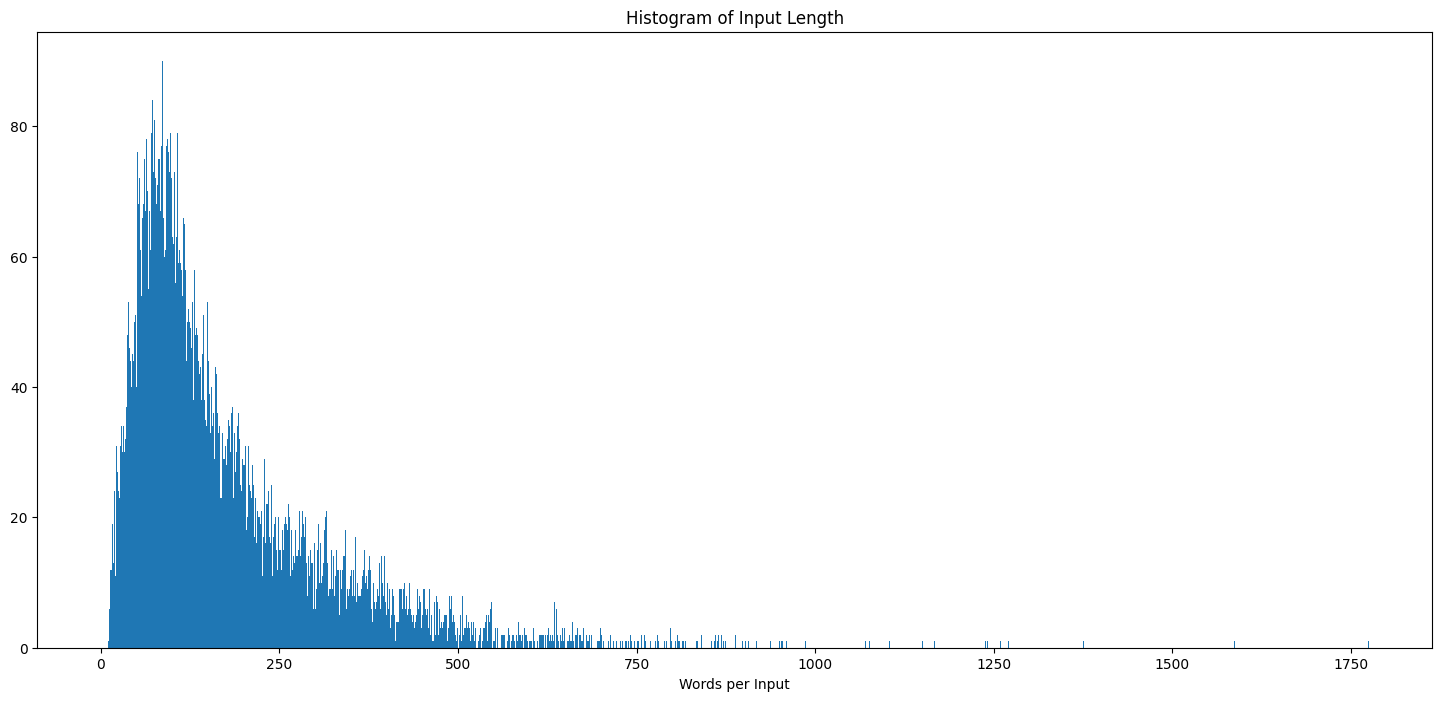

In [ ]:
para_n_question = pd.DataFrame()
para_n_question["input"] = df["context"] + df["question"]
para_n_question["input_len"] = para_n_question['input'].str.split().str.len()

n_bins = max(para_n_question["input_len"])
para_n_question.hist('input_len', grid=False, bins=n_bins, range=(0, n_bins), figsize=(18,8))
plt.suptitle('')
plt.title('Histogram of Input Length')
plt.ylabel('')
plt.xlabel('Words per Input')
plt.show()

para_n_question.drop(columns=["input", "input_len"], inplace=True)

#### Visual: Histogram of Context Lengths

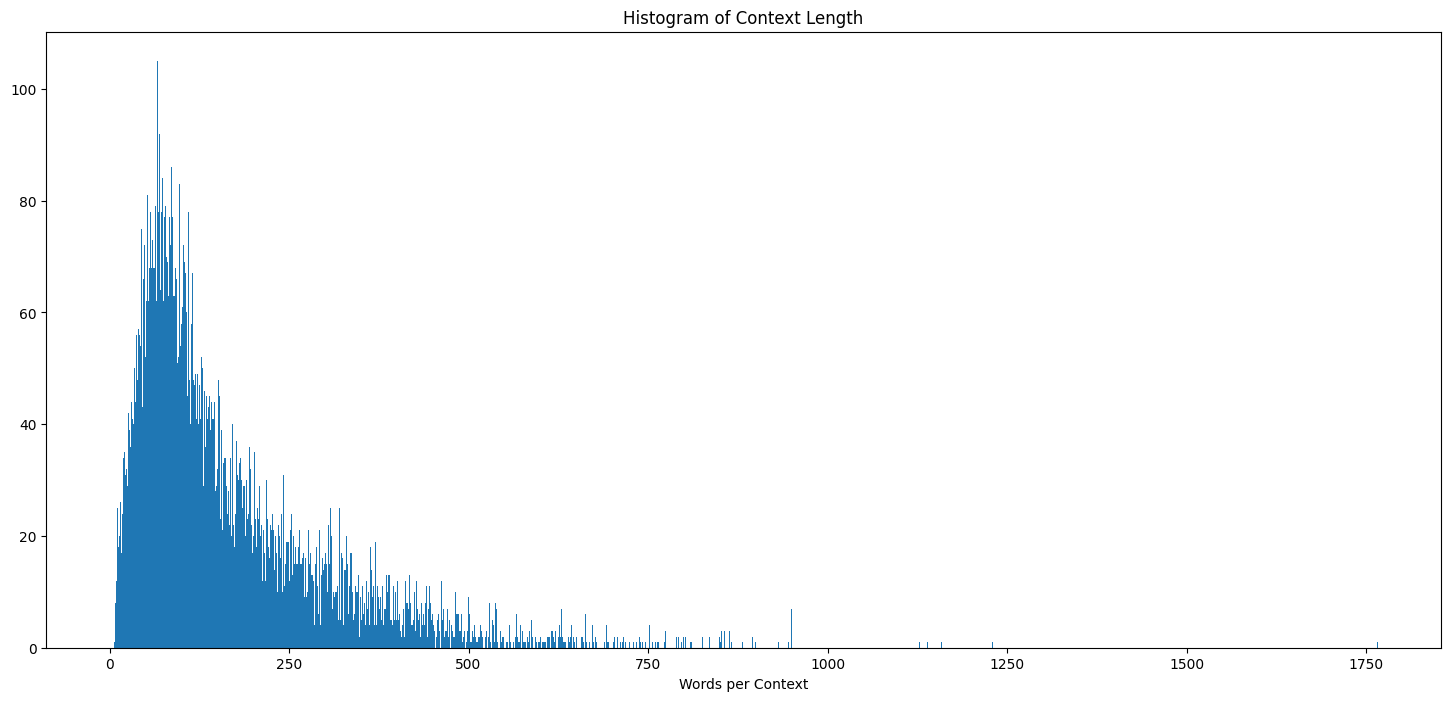

In [ ]:
df["context_len"] = df['context'].str.split().str.len()

n_bins = max(df["context_len"])
df.hist('context_len', grid=False, bins=n_bins, range=(0, n_bins), figsize=(18,8))
plt.suptitle('')
plt.title('Histogram of Context Length')
plt.ylabel('')
plt.xlabel('Words per Context')
plt.show()

#### Visual: Histogram of Question Lengths

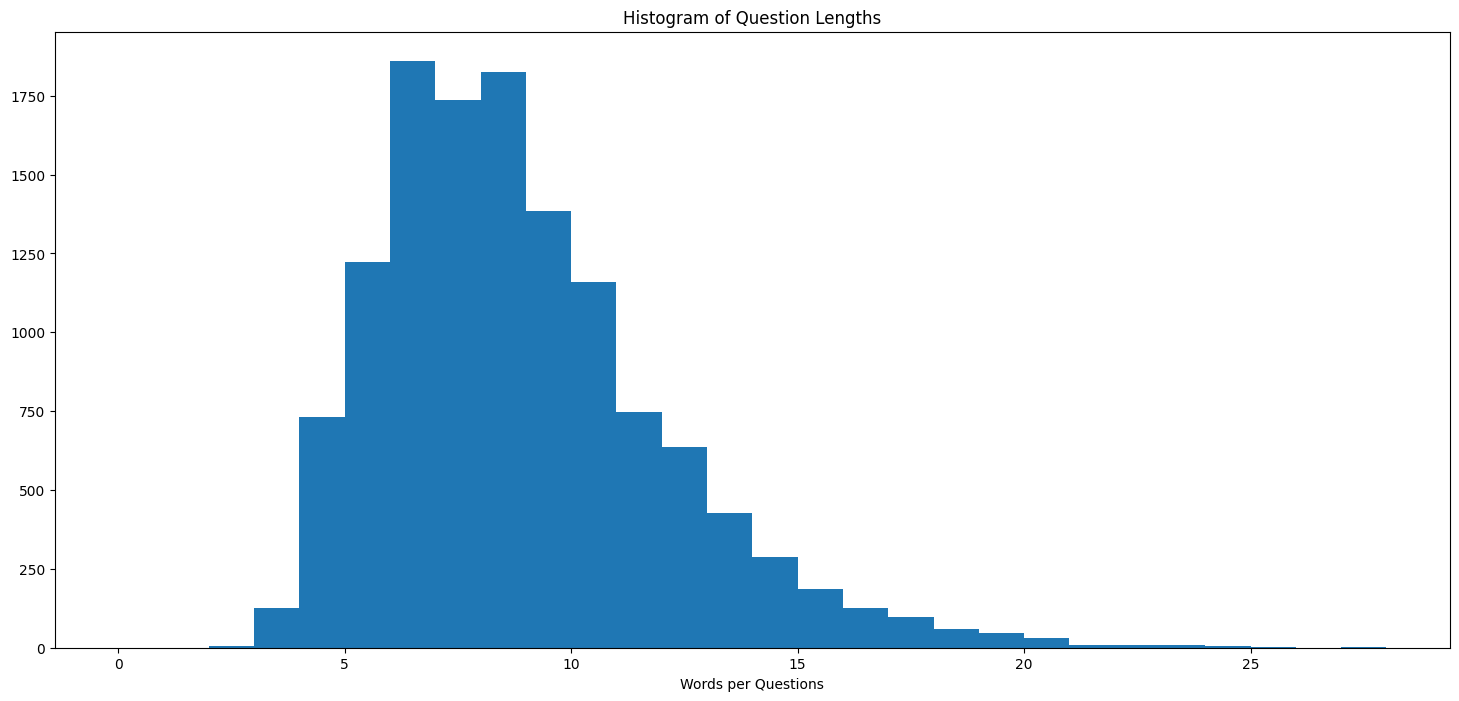

In [ ]:
df["question_len"] = df['question'].str.split().str.len()

n_bins = max(df["question_len"])
df.hist('question_len',
        grid=False,
        bins=n_bins,
        range=(0, n_bins),
        figsize=(18,8))
plt.suptitle('')
plt.title('Histogram of Question Lengths')
plt.ylabel('')
plt.xlabel('Words per Questions')
plt.show()

#### Trim Overly Lengthy Inputs

In [ ]:
df = df[df['context_len'] < 926]

df = df.drop(columns=[
    "context_len",
    "question_len"
    ]
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12713 entries, 0 to 12737
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12713 non-null  object
 1   question  12713 non-null  object
 2   answers   12713 non-null  object
 3   id        12713 non-null  object
dtypes: object(4)
memory usage: 496.6+ KB


#### Convert DataFrame to Dataset

In [ ]:
data = Dataset.from_pandas(df)

data

Dataset({
    features: ['context', 'question', 'answers', 'id', '__index_level_0__'],
    num_rows: 12713
})

#### Split Dataset into Training & Evaluation Datasets

In [ ]:
train_testvalid = data.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'eval' : train_testvalid['test']
})

print('Training data shape:', ds['train'].shape)
print('Evaluation data shape:', ds['eval'].shape)
print(ds['train'].features)

Training data shape: (10170, 5)
Evaluation data shape: (2543, 5)
{'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': {'answer_start': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, 'id': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Basic Values/Constants

In [ ]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-QnA-MLQA_Dataset"

MAX_LENGTH = 384
DOC_STRIDE = 128

DEVICE = torch.device("cuda")
set_seed(42)

LEARNING_RATE = 2e-5
NUM_OF_EPOCH = 3

WEIGHT_DECAY = 0.01

#### Function to Preprocess Training Dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def preprocess_training_ds(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=MAX_LENGTH,
        truncation="only_second",
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start & end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Else it is the start & end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

#### Apply Training Preprocessing Function to Training Dataset

In [ ]:
train_ds = ds["train"].map(
    preprocess_training_ds,
    batched=True,
    remove_columns=ds["train"].column_names,
)

len(ds["train"]), len(train_ds)

Map:   0%|          | 0/10170 [00:00<?, ? examples/s]

(10170, 12432)

In [ ]:
def preprocess_validation_ds(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=MAX_LENGTH,
        truncation="only_second",
        stride=DOC_STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

#### Apply Preprocessing Function to Evaluation Dataset

In [ ]:
eval_ds = ds["eval"].map(
    preprocess_validation_ds,
    batched=True,
    remove_columns=ds["eval"].column_names,
)
len(ds["eval"]), len(eval_ds)

Map:   0%|          | 0/2543 [00:00<?, ? examples/s]

(2543, 3107)

#### Create Function to Evaluate Model (Compute Metrics)

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples):
    metric = evaluate.load("squad")
    n_best = 20
    max_answer_length = 45

    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

#### Instantiate Model

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_CKPT)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [ ]:
args = TrainingArguments(
    MODEL_NAME,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_OF_EPOCH,
    weight_decay=WEIGHT_DECAY,
    logging_first_step=True,
    logging_steps=50,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-QnA-MLQA_Dataset into local empty directory.


#### Train Model

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1,5.914500
50,5.000700
100,4.027900
150,3.477200
200,2.764000
250,2.548800
300,2.464200
350,2.353500
400,2.083900
450,1.993200


#### Compute & Display Metrics

In [ ]:
predictions, _, _ = trainer.predict(eval_ds)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, eval_ds, ds["eval"])

  0%|          | 0/2543 [00:00<?, ?it/s]

{'exact_match': 59.61462839166339, 'f1': 73.30016374711033}

#### Push Model to Hub

In [ ]:
trainer.push_to_hub(commit_message="All DUNN!!!")

Upload file runs/Aug02_22-34-31_19b54b494945/events.out.tfevents.1691015684.19b54b494945.782.0: 100%|#########…

To https://huggingface.co/DunnBC22/bert-base-uncased-QnA-MLQA_Dataset
   3c368ac..d4f0f28  main -> main

   3c368ac..d4f0f28  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-QnA-MLQA_Dataset
   d4f0f28..d13732d  main -> main

   d4f0f28..d13732d  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-QnA-MLQA_Dataset/commit/d4f0f2858990f05fb698c88965adbb0f5e2ffca0'

#### Save Model

In [ ]:
trainer.save_model()
trainer.save_state()

### Notes & Other Takeaways
****
-

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Metric (SQuAD)
    > @inproceedings{Rajpurkar2016SQuAD10, title={SQuAD: 100, 000+ Questions for Machine Comprehension of Text}, author={Pranav Rajpurkar and Jian Zhang and Konstantin Lopyrev and Percy Liang}, booktitle={EMNLP}, year={2016}}

- Dataset
    > @article{lewis2019mlqa, title = {MLQA: Evaluating Cross-lingual Extractive Question Answering}, author = {Lewis, Patrick and Oguz, Barlas and Rinott, Ruty and Riedel, Sebastian and Schwenk, Holger}, journal = {arXiv preprint arXiv:1910.07475}, year = 2019, eid = {arXiv: 1910.07475}}